In [55]:
import math
import pandas as pd 
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style("white")

In [56]:
df = pd.read_pickle('Krogsveen.pkl')

## Estate Type

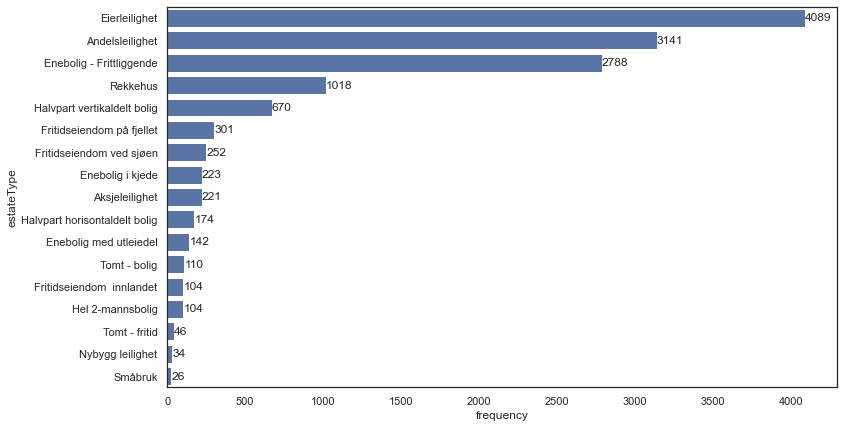

In [57]:
def plot_counts(df, field, limit):
    counts = df[field].value_counts()
    counts = counts[counts>limit]
    counts = counts.reset_index()
    counts.columns = [field, 'frequency']
    ax = sns.barplot(y=field, x = 'frequency', data=counts, color='b')
    ax.bar_label(ax.containers[0], label_type='edge')
    plt.show()
    
plot_counts(df, 'estateType', 25)

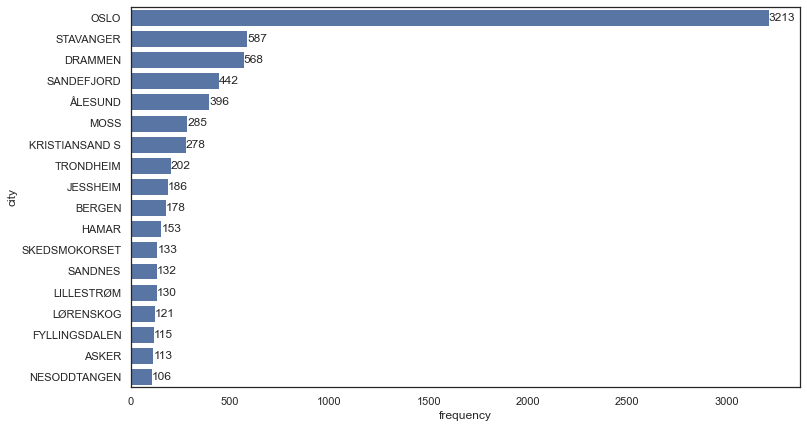

In [58]:
plot_counts(df, 'city', 100)

## Select Estate Type and City

In [102]:
dv = df[(df['estateType']=='Andelsleilighet') | (df['estateType']=='Eierleilighet') | (df['estateType']=='Rekkehus') | (df['estateType']=='Enebolig - Frittligende')]
dv = dv[dv['municipality']=='Oslo']
dv = dv[dv['status']==3]

fields = ['estateType',
          'primaryRoomArea','usableArea',
          'floor',
          'noOfBedRooms','noOfRooms','noOfBathRooms',
          'constructionYear','energyLetter',
          'collectiveDebt','rentPrMonth','zipCode',
          'latitude','longitude','createdDate',
          'soldDate',
          'soldPrice']

dv = dv[fields]
dv['noOfRooms'] = dv.apply(lambda x: x['noOfRooms'] if not np.isnan(x['noOfRooms']) else x['noOfBedRooms'], axis = 1)
dv['noOfBathRooms'] = dv['noOfBathRooms'].fillna(1)
dv['collectiveDebt'] = dv['collectiveDebt'].fillna(0)
dv['rentPrMonth'] = dv['rentPrMonth'].fillna(0)

dv = dv[~dv['constructionYear'].isna()]
dv['constructionYear'] = dv['constructionYear'].astype(int)
dv['energyLetter'] = dv['energyLetter'].astype(int)
dv['noOfRooms'] = dv['noOfRooms'].astype(int)
dv['noOfBathRooms'] = dv['noOfBathRooms'].astype(int)
dv['soldDate'] = pd.to_datetime(dv['soldDate'].str[0:10], format='%Y-%m-%d')
dv['createdDate'] = pd.to_datetime(dv['createdDate'].str[0:10], format='%Y-%m-%d')
dv.rename(columns={'createdDate':'entryDate'}, errors="raise")

dv['sqmPrice'] = dv['soldPrice'] / dv['primaryRoomArea']
dv['logPrice'] = np.log(dv['soldPrice'])

In [93]:
def remove_pct(df, field, pct):
    qmin = df[field].quantile(pct/2)
    qmax = df[field].quantile(1-pct/2)
    return df[(df[field]>=qmin) & (df[field]<=qmax)]

dv = remove_pct(dv, 'sqmPrice', 0.01)

## Impute Coordinates

In [94]:
print(len(dv[dv['latitude']==0]))
dw = dv[dv['latitude']!=0]
mean_latitude = dw['latitude'].mean()
mean_longitude = dw['longitude'].mean()
dv = dv.replace({'latitude': {0: mean_latitude}, 'longitude': {0: mean_longitude}}) 

3


## Impute Energy Letter

67


<AxesSubplot:xlabel='constructionYear', ylabel='energyLetter'>

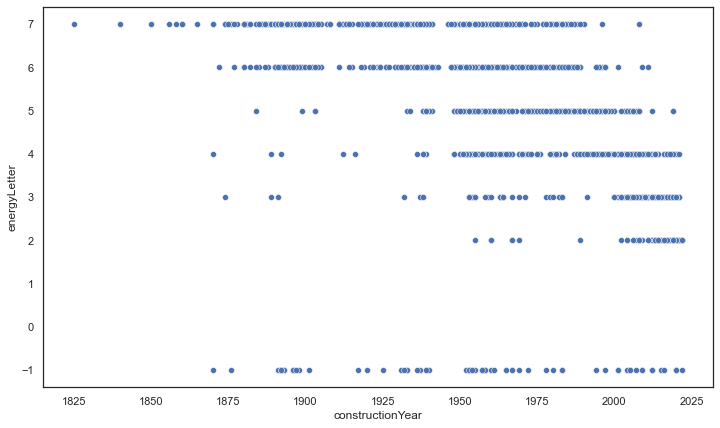

In [97]:
print(sum(dv['energyLetter']==-1))
sns.scatterplot(data=dv, y='energyLetter', x ='constructionYear')

In [81]:
dv['constructionYearGroup']=dv['constructionYear'].astype(str).str.slice(start=0, stop=3).astype(int)

def mode(a):
    u, c = np.unique(a, return_counts=True)
    if c.max()<10:
        return None
    return u[c.argmax()]

energyLetter = dv[['energyLetter', 'constructionYearGroup']]
energyLetter = energyLetter[energyLetter['energyLetter']>=0]
energyLetter = energyLetter.rename(columns = {'constructionYearGroup' : 'From'})
energyLetter = energyLetter.sort_values('From').groupby('From')['energyLetter'].apply(mode)
energyLetter = energyLetter.dropna()
energyLetter = energyLetter.reset_index()

energyLetter.loc[0, 'From'] = 0
energyLetter['To'] = energyLetter['From'].shift(-1)
energyLetter['To'] = energyLetter['To'].fillna(999)

idx = pd.IntervalIndex.from_arrays(energyLetter['From'], energyLetter['To'], closed='left')
energyLetter = energyLetter.set_index(idx)['energyLetter']
energyLetter

[0.0, 188.0)      7.0
[188.0, 189.0)    7.0
[189.0, 190.0)    7.0
[190.0, 191.0)    7.0
[191.0, 192.0)    7.0
[192.0, 193.0)    7.0
[193.0, 194.0)    7.0
[194.0, 195.0)    6.0
[195.0, 196.0)    7.0
[196.0, 197.0)    7.0
[197.0, 198.0)    5.0
[198.0, 199.0)    5.0
[199.0, 200.0)    5.0
[200.0, 201.0)    4.0
[201.0, 202.0)    3.0
[202.0, 999.0)    2.0
Name: energyLetter, dtype: float64

In [82]:
dv['energyLetterEstimate'] = dv['constructionYearGroup'].map(energyLetter)
dv['energyLetter'] = dv.apply(lambda x: x['energyLetter'] if x['energyLetter'] != -1 else x['energyLetterEstimate'], axis=1)
dv.drop(columns=['constructionYearGroup', 'energyLetterEstimate'], inplace=True)

## Data

In [84]:
dv.head(10)

,estateType,primaryRoomArea,usableArea,floor,noOfBedRooms,noOfRooms,noOfBathRooms,constructionYear,energyLetter,collectiveDebt,rentPrMonth,zipCode,latitude,longitude,createdDate,soldPrice,sqmPrice,logPrice
1,Andelsleilighet,67.0,67.0,1,2,3,1,1955,6.0,60281.0,75.910448,0588,59.942715,10.802039,2021-01-26,5000000.0,74626.865672,15.424948
3,Andelsleilighet,46.0,46.0,4,1,2,1,1893,7.0,10000.0,48.347826,0177,59.918365,10.745997,2021-09-13,4400000.0,95652.173913,15.297115
5,Eierleilighet,88.0,97.0,1,3,4,2,2019,3.0,0.0,48.522727,0579,59.928588,10.791781,2021-11-17,8500000.0,96590.909091,15.955577
6,Andelsleilighet,59.0,59.0,1,2,3,1,1983,6.0,1349964.0,151.898305,0490,59.950636,10.796166,2021-06-15,4110000.0,69661.016949,15.228934
15,Andelsleilighet,69.0,77.0,1,2,3,1,1960,7.0,126105.0,44.710145,0689,59.881397,10.855112,2022-04-05,5000000.0,72463.768116,15.424948
16,Eierleilighet,58.0,58.0,5,2,3,1,1937,7.0,95061.0,69.637931,0452,59.929034,10.733853,2022-05-13,7260000.0,125172.413793,15.797890
18,Andelsleilighet,86.0,86.0,4,3,3,1,1967,2.0,596139.0,73.523256,0670,59.917500,10.844516,2021-04-30,4500000.0,52325.581395,15.319588
23,Andelsleilighet,51.0,51.0,1,2,3,1,1885,7.0,163232.0,70.647059,0187,59.914199,10.766169,2021-07-01,3950000.0,77450.980392,15.189226
31,Eierleilighet,82.0,83.0,0,2,3,1,1899,5.0,0.0,36.012195,0562,59.920517,10.763123,2020-09-25,6030000.0,73536.585366,15.612258
33,Eierleilighet,98.0,98.0,4,3,4,1,2008,4.0,10000.0,60.561224,0661,59.919731,10.789095,2022-03-10,9605000.0,98010.204082,16.077794


In [85]:
dv.describe()

,primaryRoomArea,usableArea,floor,noOfBedRooms,noOfRooms,noOfBathRooms,constructionYear,energyLetter,collectiveDebt,rentPrMonth,latitude,longitude,soldPrice,sqmPrice,logPrice
count,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2.541000e+03,2541.000000,2541.000000,2541.000000,2.541000e+03,2541.000000,2541.000000
mean,67.591893,69.413420,2.848091,1.831956,2.819756,1.075561,1965.963007,5.333727,1.703330e+05,63.323448,59.920599,10.788210,5.472223e+06,83301.935793,15.441926
std,26.323291,27.916044,1.940996,0.870615,1.001072,0.276004,37.687173,1.571022,3.655397e+05,31.442870,0.026588,0.050015,2.288539e+06,20211.433883,0.371986
min,15.000000,15.000000,-4.000000,0.000000,0.000000,1.000000,1825.000000,2.000000,0.000000e+00,0.000000,59.822593,10.630019,1.630000e+06,37109.375000,14.304091
25%,51.000000,52.000000,1.000000,1.000000,2.000000,1.000000,1951.000000,4.000000,0.000000e+00,47.546875,59.910997,10.763138,3.925000e+06,68852.459016,15.182877
50%,65.000000,66.000000,3.000000,2.000000,3.000000,1.000000,1962.000000,6.000000,7.028300e+04,57.553191,59.923840,10.790276,4.800000e+06,82196.969697,15.384126
75%,79.000000,81.000000,4.000000,2.000000,3.000000,1.000000,2002.000000,7.000000,1.930000e+05,71.017857,59.938208,10.816828,6.355555e+06,95833.333333,15.664840
max,223.000000,262.000000,14.000000,6.000000,11.000000,3.000000,2022.000000,7.000000,6.300000e+06,358.055556,59.974907,10.945190,1.800000e+07,160000.000000,16.705882


## Save

In [68]:
dv.to_pickle('../assets/Oslo.pkl')